<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap10/10_5_Convolution_For_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 10.5: Convolution for MNIST**

This notebook builds a proper network for 2D convolution.  It works with the MNIST dataset (figure 15.15a), which was the original classic dataset for classifying images.  The network will take a 28x28 grayscale image and classify it into one of 10 classes representing a digit.

The code is adapted from https://nextjournal.com/gkoehler/pytorch-mnist

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.


In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random

In [2]:
# Run this once to load the train and test data straight into a dataloader class
# that will provide the batches
batch_size_train = 64
batch_size_test = 1000
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 32703304.68it/s]


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1079236.77it/s]


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9260118.07it/s]


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 896368.93it/s]


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



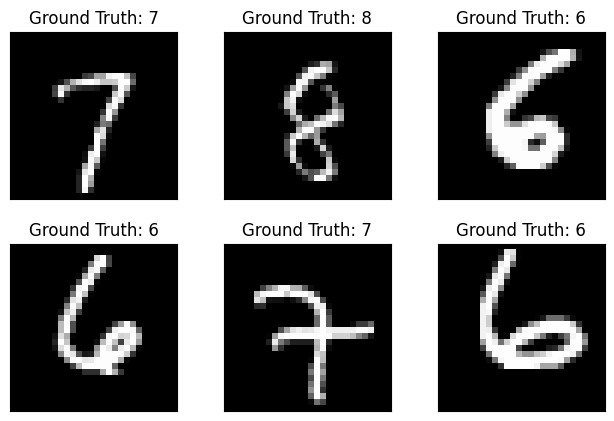

In [3]:
# Let's draw some of the training data
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

Define the network.  This is a more typical way to define a network than the sequential structure.  We define a class for the network, and define the parameters in the constructor.  Then we use a function called forward to actually run the network.  It's easy to see how you might use residual connections in this format.

In [7]:
from os import X_OK


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1. Valid convolution with kernel size 5, 1 input channel, 10 output channels
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1, padding=0)
        # 2. Max pooling operation over a 2x2 area
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # 3. ReLU activation
        self.relu1 = nn.ReLU()
        # 4. Valid convolution with kernel size 5, 10 input channels, 20 output channels
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1, padding=0)
        # 5. 2D Dropout layer
        self.drop = nn.Dropout2d(p=0.5)  # Dropout probability of 0.5
        # 6. Max pooling operation over a 2x2 area
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # 7. ReLU activation
        self.relu2 = nn.ReLU()
        # 8. Flattening operation
        self.fl = nn.Flatten()
        # 9. Fully connected layer mapping from flattened dimensions to 50
        self.fc1 = nn.Linear(20 * 4 * 4, 50)
        # 10. ReLU activation
        self.relu3 = nn.ReLU()
        # 11. Fully connected layer mapping from 50 to 10 dimensions
        self.fc2 = nn.Linear(50, 10)
        # 12. Softmax function
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Apply the first convolutional layer
        x = self.conv1(x)
        # Apply max pooling
        x = self.pool1(x)
        # Apply ReLU activation
        x = self.relu1(x)
        # Apply the second convolutional layer
        x = self.conv2(x)
        # Apply dropout
        x = self.drop(x)
        # Apply max pooling
        x = self.pool2(x)
        # Apply ReLU activation
        x = self.relu2(x)
        # Flatten the output
        x = self.fl(x)
        # Apply the first fully connected layer
        x = self.fc1(x)
        # Apply ReLU activation
        x = self.relu3(x)
        # Apply the second fully connected layer
        x = self.fc2(x)
        # Apply softmax function
        x = self.softmax(x)
        return x



In [8]:
# He initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

In [9]:
# Create network
model = Net()
# Initialize model weights
model.apply(weights_init)
# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [10]:
# Main training routine
def train(epoch):
  model.train()
  # Get each
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    # Store results
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset), loss.item()))

In [11]:
# Run on test data
def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [12]:
# Get initial performance
test()
# Train for three epochs
n_epochs = 3
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: -0.0984, Accuracy: 769/10000 (8%)

Train Epoch: 1 [0/60000]	Loss: -0.093256
Train Epoch: 1 [640/60000]	Loss: -0.088053
Train Epoch: 1 [1280/60000]	Loss: -0.086134
Train Epoch: 1 [1920/60000]	Loss: -0.115544
Train Epoch: 1 [2560/60000]	Loss: -0.113057
Train Epoch: 1 [3200/60000]	Loss: -0.120713
Train Epoch: 1 [3840/60000]	Loss: -0.123755
Train Epoch: 1 [4480/60000]	Loss: -0.116267
Train Epoch: 1 [5120/60000]	Loss: -0.172304
Train Epoch: 1 [5760/60000]	Loss: -0.170143
Train Epoch: 1 [6400/60000]	Loss: -0.172301
Train Epoch: 1 [7040/60000]	Loss: -0.154382
Train Epoch: 1 [7680/60000]	Loss: -0.125836
Train Epoch: 1 [8320/60000]	Loss: -0.173043
Train Epoch: 1 [8960/60000]	Loss: -0.189123
Train Epoch: 1 [9600/60000]	Loss: -0.176600
Train Epoch: 1 [10240/60000]	Loss: -0.177327
Train Epoch: 1 [10880/60000]	Loss: -0.160656
Train Epoch: 1 [11520/60000]	Loss: -0.256237
Train Epoch: 1 [12160/60000]	Loss: -0.221599
Train Epoch: 1 [12800/60000]	Loss: -0.261109
Train Epoch: 1 [13

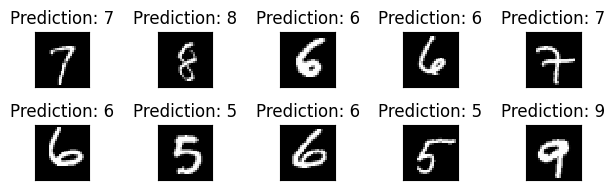

In [13]:
# Run network on data we got before and show predictions
output = model(example_data)

fig = plt.figure()
for i in range(10):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
plt.show()